In [1]:
#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
from cvxpy import *
import l2distance
import visclassifier
#</GRADED>
import matplotlib
#matplotlib.use('PDF')
import matplotlib.pyplot as plt


%matplotlib inline

from scipy.stats import linregress

import pylab
from matplotlib.animation import FuncAnimation

%matplotlib notebook

<!--announcements-->
<blockquote>
    <center>
    <img src="yinyang.png" width="400px" /></a>
    </center>
      <p><cite><center>"Just as we have two eyes and two feet,<br>
      duality is part of life."<br>
<b>--Carlos Santana</b><br>
      </center></cite></p>
</blockquote>


<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. You will be using <code>cvxpy</code>. Before we get started please read through the <a href="http://www.cvxpy.org/en/latest/tutorial/index.html">tutorial</a> of cvxpy and its quadratic programming solver.

<h4> Linear classification</h4>

<p> The first assignment is to implement a linear support vector machine. Before we get started we can generate some data to see if everything is working:  
</p>

In [45]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separagle labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return xTr, yTr

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Currently, the code below is a placeholder example of a <code>cvxpy</code> optimization problem. You need to update the objective, the constraints and introduce new variables to output the correct hyperplane and bias. </p>

In [50]:
#<GRADED>
def primalSVM(xTr, yTr, C=1):
    """
    function (classifier,w,b) = primalSVM(xTr,yTr;C=1)
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (n)
        C     | the SVM regularization parameter
    
    Output:
        fun   | usage: predictions=fun(xTe); predictions.shape = (n,)
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    N, d = xTr.shape
    y = yTr.flatten()
    ## Solution Start
    w = Variable(d)
    b = Variable(1)
    xi = Variable(N)
    objective = Minimize(sum_squares(w) + C * sum(xi))
    constraints = [xi >= 0, multiply(yTr, (xTr @ w + b)) >= 1 - xi]
    prob = Problem(objective, constraints)
    prob.solve()
    wout = w.value
    bout = b.value
    ## Solution End
    
    fun = lambda x: x.dot(wout) + bout
    return fun, wout, bout
#</GRADED>

We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

In [51]:
def arrayify(x):
    """flattens and converts to numpy"""
    return np.array(x).flatten()

<IPython.core.display.Javascript object>


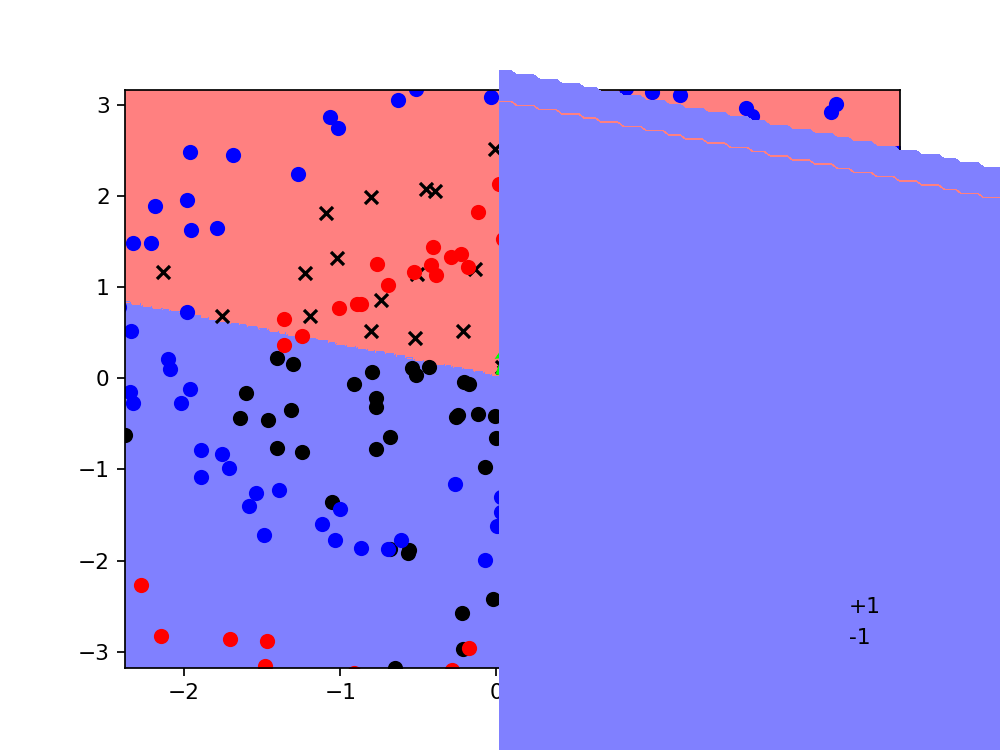

Training error: 0.0%


In [52]:
xTr,yTr=genrandomdata()
fun,w,b=primalSVM(xTr,yTr,C=15)
visclassifier.visclassifier(fun,xTr,yTr,w=w,b=b)


err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

In [53]:
w, b

(array([2.05209094, 6.04916329]), array([-0.24085063]))

### Helper functions used to create animation

In [54]:
def updateboundary():
    global w,b,Xdata,ldata,stepsize

    _, w_pre, b_pre = primalSVM(np.transpose(Xdata),np.array(ldata),C=10)
    w = np.array(w_pre).reshape(-1)
    b = b_pre
    stepsize+=1

def updatescreen():
    global w,b,ax,line 
    q=-b/(w**2).sum()*w;
    if line==None:
        line, = ax.plot([q[0]-w[1],q[0]+w[1]],[q[1]+w[0],q[1]-w[0]],'b--')
    else:
        line.set_ydata([q[1]+w[0],q[1]-w[0]])
        line.set_xdata([q[0]-w[1],q[0]+w[1]])
    
def animate(i):
    if len(ldata)>0 and (min(ldata)+max(ldata)==0):
        if stepsize<1000:
            updateboundary()
            updatescreen();
    
def onclick(event):
    global Xdata, stepsize  
    if event.key == 'shift': # add positive point
        ax.plot(event.xdata,event.ydata,'or')
        label=1
    else: # add negative point
        ax.plot(event.xdata,event.ydata,'ob')
        label=-1    
    pos=np.array([[event.xdata],[event.ydata]])
    ldata.append(label);
    Xdata=np.hstack((Xdata,pos))
    stepsize=1;

### Animation

<IPython.core.display.Javascript object>


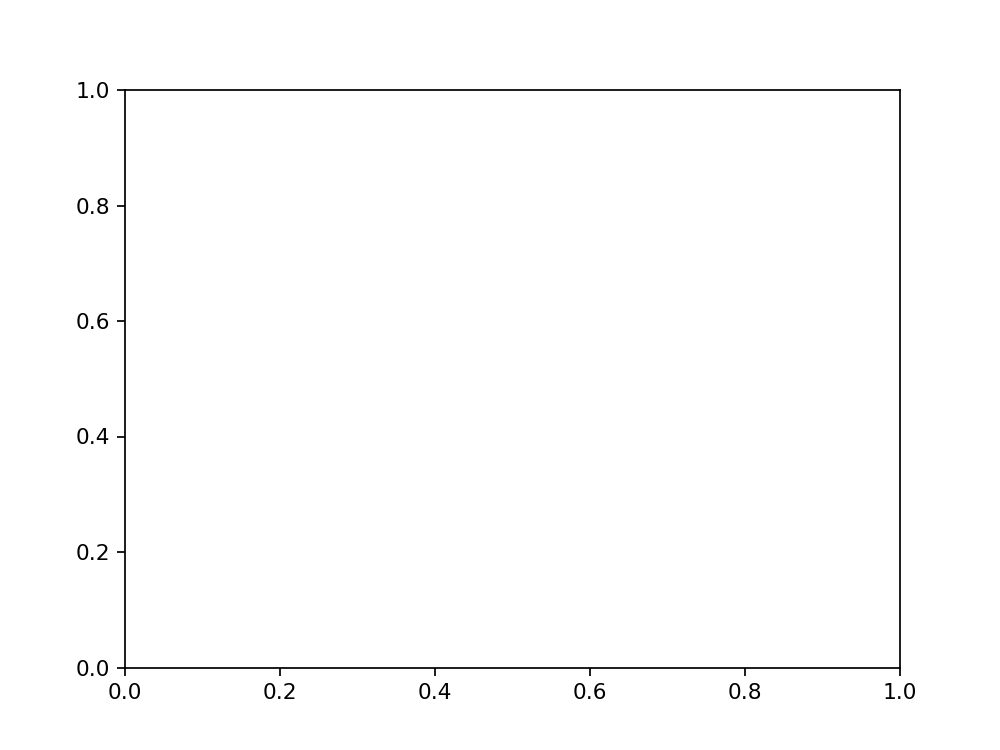

In [55]:
Xdata=pylab.rand(2,0)
ldata=[]
w=[]
b=[]
line=None
stepsize=1;
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
ani = FuncAnimation(fig, animate,pylab.arange(1,100,1),interval=10);

<h4>Spiral data set</h4>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [56]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    multiply
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

In [57]:
xTr,yTr,xTe,yTe=spiraldata()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

In [60]:
fun,w,b=primalSVM(xTr,yTr,C=10)

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [59]:
fun, w, b

(<function __main__.primalSVM.<locals>.<lambda>(x)>, [], [])

<IPython.core.display.Javascript object>


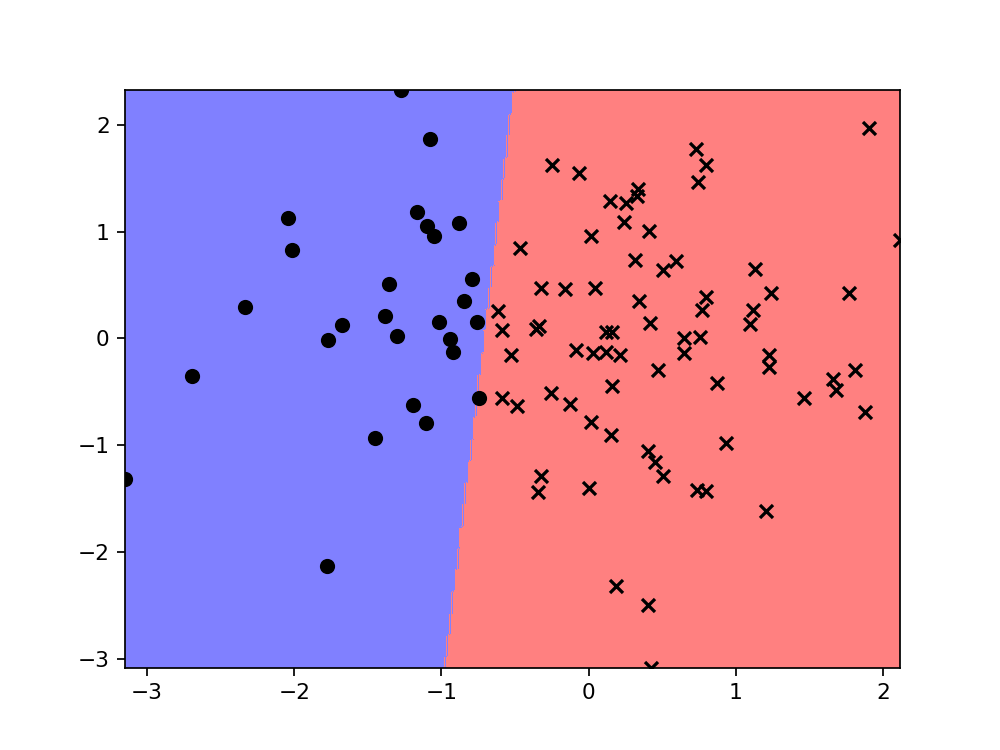

Training error: 1.0%


In [68]:
visclassifier.visclassifier(fun,xTr,yTr,w=[],b=0)
err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kerneltype,X,Z,kpar)</pre>
It takes as input a kernel type (kerneltype) and two data sets $\mathbf{X}$ in $\mathcal{R}^{n\times d}$ and $\mathbf{Z}$ in $\mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>ktype='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>ktype='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed a the value of kpar)</li>
	<li>For the polynomial kernel (<code>ktype='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction.</p>





In [16]:
#<GRADED>
def computeK(kerneltype, X, Z, kpar=0.05):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    ## Solution Start
    K = None
    if kerneltype == 'linear':
        K = X.dot(Z.T)
    elif kerneltype == 'polynomial' or kerneltype == 'poly':
        K = (1 + X.dot(Z.T))**kpar
    elif kerneltype == 'rbf':
        D = (l2distance.l2distance(X, Z))**2
        assert D.shape[0] == X.shape[0]
        assert D.shape[1] == Z.shape[0]
        expo = -D * (kpar)
#         print(expo[0][:20])
        K = np.exp(expo)
#         print(K[0][:20])
    ## Solution End
    
    return K
#</GRADED>

<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

<IPython.core.display.Javascript object>


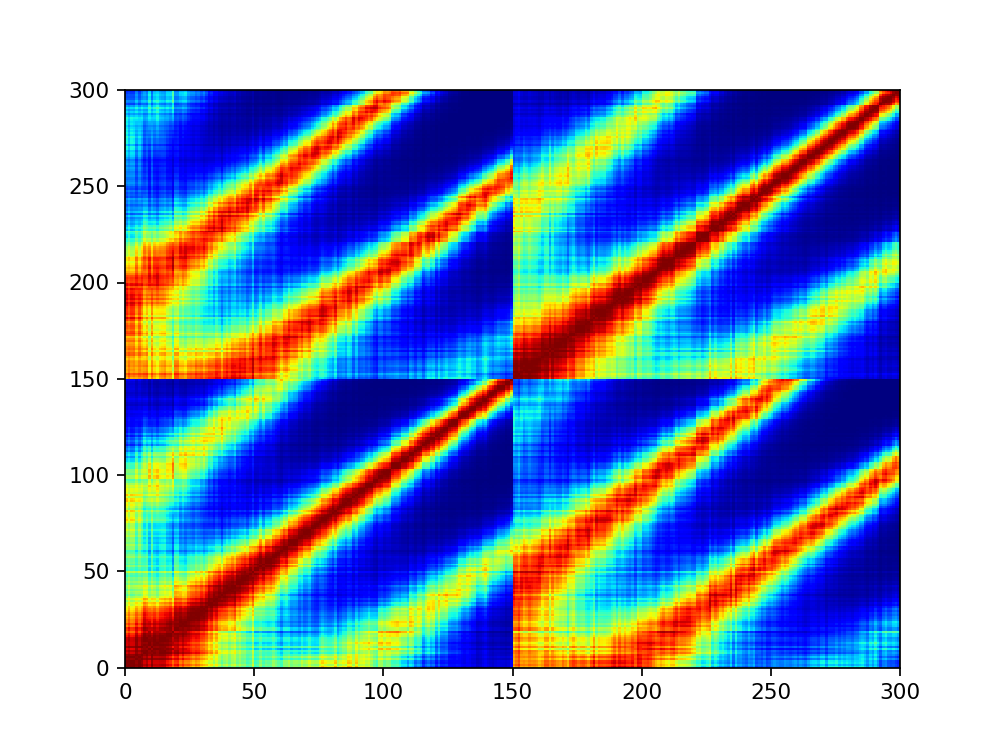

In [17]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.pcolormesh(K, cmap='jet')
plt.show()

Remember that the SVM optimization has the following dual formulation:
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$.  Please note that here all $\alpha_i\geq 0$, which is possible because we multiply by $y_i$ in the definition of $\mathbf{w}$. One advantage of keeping all $\alpha_i$ non-negative is that we can easily identify non-support vectors as vectors with $\alpha_i=0$. 

<p>Implement the function <code>dualqp</code>, which takes as input a kernel matrix $K$, a vector of labels $yTr$ in $\mathcal{R}^{n}$, and a regularization constant $C\geq 0$. This function should solve the quadratic optimization problem and output the optimal vector $\mathbf{\alpha}\in{\mathcal{R}^n}$.</p>



In [27]:
#<GRADED>
def dualqp(K,yTr,C):
    """
    function alpha = dualqp(K,yTr,C)
    constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        K     | the (nxn) kernel matrix
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
    
    Output:
        alpha | the calculated solution vector (nx1)
    """
    K = cvxpy.atoms.affine.wraps.psd_wrap(K)
    y = yTr.flatten()
    N, _ = K.shape
    alpha = Variable(N)
    
    ## Solution Start
#     print(K)
#     print(all(np.linalg.eigvals(K)>=0))
#     objective = Minimize(0.5 * alpha.T  * K * alpha - sum(alpha))
    objective = Minimize(0.5 * quad_form(multiply(alpha, yTr), K) - sum(alpha))
    constraints = [
        alpha >= 0,
        alpha <= C,
        yTr.T @ alpha == 0
    ]
    prob = Problem(objective, constraints)
    prob.solve()
#     print(prob.status)
#     print(alpha.value)
    
    ## Solution End
    
    return np.array(alpha.value).flatten()
#</GRADED>

The following code shows a usecase of how <code>dualqp</code> could be used in practice. 

In [28]:
C = 10
lmbda = 0.25
ktype = "rbf"
xTr,yTr,xTe,yTe=spiraldata()
# compute kernel (make sure it is PSD)
K = computeK(ktype,xTr,xTr, lmbda)

In [29]:
K

array([[1.00000000e+00, 9.77279551e-01, 9.39533670e-01, ...,
        1.24261607e-04, 1.27128020e-04, 4.45729235e-05],
       [9.77279551e-01, 1.00000000e+00, 9.90222410e-01, ...,
        1.12520154e-04, 1.17156849e-04, 4.56964607e-05],
       [9.39533670e-01, 9.90222410e-01, 1.00000000e+00, ...,
        9.25746735e-05, 9.74835031e-05, 4.04707870e-05],
       ...,
       [1.24261607e-04, 1.12520154e-04, 9.25746735e-05, ...,
        1.00000000e+00, 9.96645155e-01, 8.20714739e-01],
       [1.27128020e-04, 1.17156849e-04, 9.74835031e-05, ...,
        9.96645155e-01, 1.00000000e+00, 8.57876816e-01],
       [4.45729235e-05, 4.56964607e-05, 4.04707870e-05, ...,
        8.20714739e-01, 8.57876816e-01, 1.00000000e+00]])

In [30]:
eps = 1e-10
# make sure it is symmetric and positive semi-definite
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])

In [31]:
K

array([[1.00000000e+00, 9.77279551e-01, 9.39533670e-01, ...,
        1.24261607e-04, 1.27128020e-04, 4.45729235e-05],
       [9.77279551e-01, 1.00000000e+00, 9.90222410e-01, ...,
        1.12520154e-04, 1.17156849e-04, 4.56964607e-05],
       [9.39533670e-01, 9.90222410e-01, 1.00000000e+00, ...,
        9.25746735e-05, 9.74835031e-05, 4.04707870e-05],
       ...,
       [1.24261607e-04, 1.12520154e-04, 9.25746735e-05, ...,
        1.00000000e+00, 9.96645155e-01, 8.20714739e-01],
       [1.27128020e-04, 1.17156849e-04, 9.74835031e-05, ...,
        9.96645155e-01, 1.00000000e+00, 8.57876816e-01],
       [4.45729235e-05, 4.56964607e-05, 4.04707870e-05, ...,
        8.20714739e-01, 8.57876816e-01, 1.00000000e+00]])

In [32]:
K.shape

(300, 300)

In [33]:
alpha=dualqp(K,yTr,C)

In [34]:
alpha

array([ 1.00000000e+01,  5.85075028e-20,  4.68270951e-01,  3.21447869e-20,
       -1.17329894e-19, -9.93764420e-20, -2.02121980e-19,  1.97882806e-20,
       -2.00795331e-19, -2.07742563e-19, -2.10147226e-19, -2.59275696e-19,
       -2.60590322e-19, -2.59401339e-19, -1.70244378e-19, -1.73273949e-19,
       -5.80516251e-20, -8.57420036e-20, -1.21093204e-19, -2.34008955e-19,
        6.41763830e-02,  3.72373341e-20,  4.04516528e-20,  1.00000000e+01,
        6.95471167e-21,  6.14631554e-20,  8.35170040e-20,  8.24802632e-20,
        1.33102693e-19,  1.72661062e-20,  1.77662231e+00,  8.53490955e-20,
        1.51529566e-19,  2.10161559e-20,  2.69464057e-19,  1.74420297e-19,
        2.27881781e-19,  2.65018027e-19,  2.36891957e-19,  2.15464479e-19,
        1.00000000e+01,  2.20995338e-19,  8.50533302e-20,  2.03845821e+00,
        2.91846648e-20, -3.32804060e-20, -6.59370608e-20, -6.83588611e-20,
        8.81164806e+00,  5.12479428e-20,  2.68651339e-20,  1.12441863e-19,
        1.25926914e-19,  

<p> Now that you can solve the dual correctly, you should have the values for $\alpha_i$. But you are not done yet. You still need to be able to classify new test points. Remember from class that $h(\mathbf{x})=\sum_{i=1}^n \alpha_i y_i k(\mathbf{x}_i,\mathbf{x})+b$. You need to obtain $b$. It is easy to show (and omitted here) that if $C>\alpha_i>0$ (with strict $>$), then we must have that $y_i(\mathbf{w}^\top \phi(\mathbf{x}_i)+b)=1$. Rephrase this equality in terms of $\alpha_i$ and solve for $b$. Implement

<p> b=recoverBias(K,yTr,alphas,C); </p>

<p> where <code>b</code> is the hyperplane bias.
(Hint: This is most stable if you pick an $\alpha_i$ that is furthest from $C$ and $0$. )</p>

<p>Please note that this use of the word bias has absolutely nothing to do with the word bias in the bias variance trade-off. It is just the same word but two completely different meanings. This unfortunate term collision comes from the fact that we are borrowing concepts from geometry and statistics.</p>

In [61]:
#<GRADED>
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : nx1 input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """

    ## Solution Start

    idx = np.argmin(np.abs(alpha - C*0.5))
   
    bias = yTr[idx] - np.multiply(yTr , alpha).dot(K[:,idx])
    ## Solution End
    
    return bias
#</GRADED>

<p> Test your <b><code>recoverBias</code></b> function with the following code, which uses the dual solver on a linearly separable dataset:</p>

In [65]:
xTr,yTr=genrandomdata(b=0.5)
C=10
K=computeK("linear",xTr,xTr)
eps=1e-10
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
alpha = dualqp(K,yTr,C)
ba=recoverBias(K,yTr,alpha,C)
wa = (alpha * yTr).dot(xTr)

AAA idx is 11


In [66]:
wa, ba

(array([ 5.94310731, -0.51435995]), 4.202662574291166)

<IPython.core.display.Javascript object>


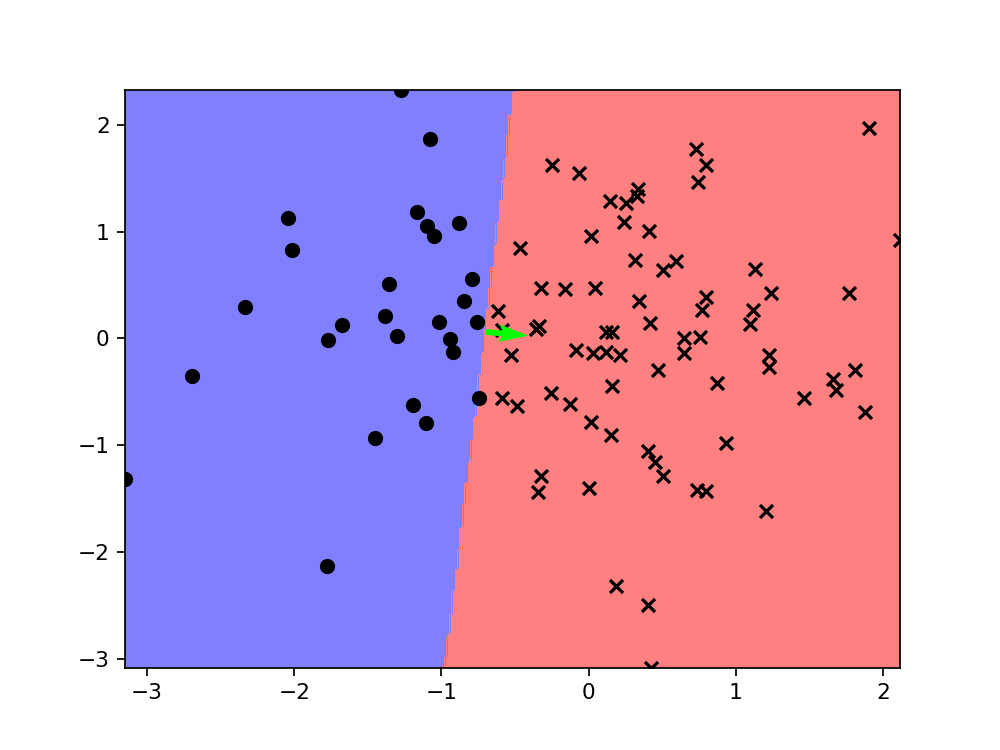

In [69]:
fun = lambda x: x.dot(wa) + ba
visclassifier.visclassifier(fun, xTr, yTr, w=wa, b=ba)

<p>
    Implement the function 
    <pre>
    svmclassify=dualSVM(xTr,yTr,C,ktype,kpar);
    </pre>
    It should use your functions <code><b>computeK</b></code> and <code><b>generateQP</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>, to be used as kpar in Kernel construction). Then, find the support vectors and recover the bias to return <b><code>svmclassify</code></b>, a function that uses your SVM to classify a set of test points <code>xTe</code>.

<b>Hint: You need to ensure that the kernel matrix is positive semi-definite during training. The best way to do this is to make sure it is strictly symmetric and to add the identity matrix to it, multiplied by a tiny epsilon value.</b>
    
</p>


In [70]:
#<GRADED>
def testkernel(X,Z,kpar):
    D = (l2distance.l2distance(X, Z))**2
    expo = -D * (kpar)
#         print(expo[0][:20])
    K = np.exp(expo)

def dualSVM(xTr,yTr,C,ktype,lmbda,eps=1e-10):
    """
    function classifier = dualSVM(xTr,yTr,C,ktype,lmbda);
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
        ktype | the type of kernelization: 'rbf','polynomial','linear'
        lmbda | the kernel parameter - degree for poly, inverse width for rbf
    
    Output:
        svmclassify | usage: predictions=svmclassify(xTe);
    """
    
    
    # Solution Start
    K = computeK(ktype, xTr, xTr,lmbda)

    K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
    alpha = dualqp(K,yTr,C)
    ba=recoverBias(K,yTr,alpha,C)
  

  #  svmclassify = lambda x: computeK(ktype, xTr, xTr[0],lmbda).dot((alpha * yTr))+ba #Dummy code

    svmclassify = lambda x: np.dot(np.multiply(alpha,yTr),computeK(ktype, xTr, x, lmbda))+ba
    # Solution End
    
   
    
    return svmclassify
#</GRADED>

<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

AAA idx is 94


<IPython.core.display.Javascript object>


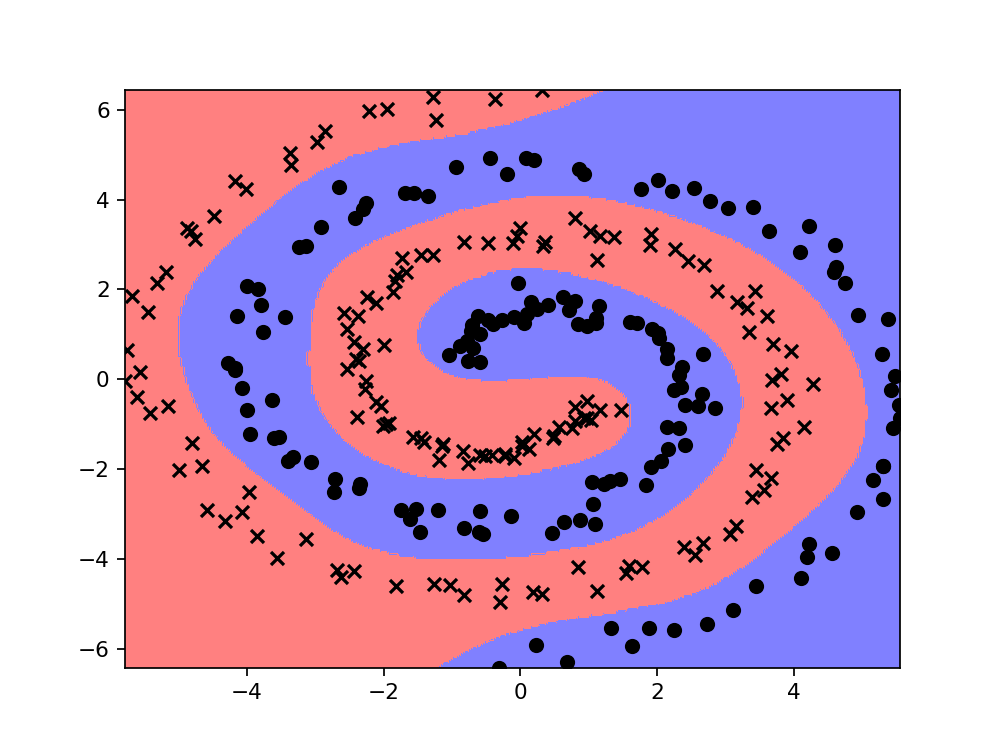

Training error: 0.0000
Testing error: 0.0033


In [72]:
xTr,yTr,xTe,yTe=spiraldata()
C=10.0
sigma=0.25
ktype="rbf"
svmclassify=dualSVM(xTr,yTr,C,ktype,sigma)

visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

SVMs are pretty sensitive to hyper-parameters. We can visualize the results of a hyper-parameter grid search as a heat-map, where we sweep across different values of C and kpar and output the result on a validation dataset. Now we ask you to implement a cross-validation function.

In [73]:
#<GRADED>
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    # gridsearch for best parameters
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.
    
    # Start Solution
    min_error=float('inf')
    for i in range(len(CList)):
        C = CList[i]
        for j in range(len(lmbdaList)):
            lmbda=lmbdaList[j]
            svmclassify = dualSVM(xTr,yTr,C,ktype,lmbda)
            pre = svmclassify(xValid)
            error = np.mean(np.sign(pre) != yValid)
            ErrorMatrix[i, j] = error
            if error < min_error:
                min_error = error
                bestC = C
                bestlmbda = lmbda
    # End Solution
            
    return bestC,bestLmbda,ErrorMatrix
#</GRADED>

In [74]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))

bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)

plt.pcolormesh(ErrorMatrix, cmap='jet')
plt.colorbar()
plt.xlabel("lmbda_idx")
plt.ylabel("C_idx")
plt.title("Validation error")

AAA idx is 8
AAA idx is 6
AAA idx is 57
AAA idx is 11
AAA idx is 57
AAA idx is 7
AAA idx is 93
AAA idx is 73
AAA idx is 91
AAA idx is 39
AAA idx is 39
AAA idx is 91
AAA idx is 66
AAA idx is 32
AAA idx is 9
AAA idx is 56
AAA idx is 33
AAA idx is 20
AAA idx is 16
AAA idx is 4
AAA idx is 55
AAA idx is 49
AAA idx is 4
AAA idx is 46
AAA idx is 46
AAA idx is 12
AAA idx is 32
AAA idx is 51
AAA idx is 51
AAA idx is 46
AAA idx is 12
AAA idx is 12
AAA idx is 51
AAA idx is 51
AAA idx is 46


Text(0.5, 1.0, 'Validation error')

If you implemented everything correctly, the result should look similar to this image:
<center>
 <img src="crossval.png" width="300px" />
</center>

Competition: we ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get extra credit for the competition if you can beat the base benchmark of 34% error rate.

In [75]:
#<GRADED>
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    
     cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)
    
    """
    length=xTr.shape[0]
    last_idx=0
    folds=5 #k-fold cross validation
    ktype="rbf"
    p=np.random.permutation(len(xTr))
    t=0
    min_error=float('inf')
   
    while(t<30):
        C=np.random.uniform(1,20)
        lmbda=np.random.uniform(0, 1)  
        err=np.zeros((folds),dtype=float)

        for i in range (folds):
            n1=last_idx    
            n2=int(length/folds)
            tst_idx=p[n1:n1+n2]
            trn_idx=np.delete(p, tst_idx)

            last_idx=n1+n2

            xtrn = xTr[trn_idx]
            ytrn = yTr[trn_idx]
            xval = xTr[tst_idx]
            yval = yTr[tst_idx]
            
            svmclassify = dualSVM(xtrn,ytrn,C,ktype,lmbda)
            pre = svmclassify(xval)
            error = np.mean(np.sign(pre) != yval)
            err[i]=error
        avg_error=np.mean(err)    
        if avg_error < min_error:
            min_error=avg_error
            bestC = C
            bestlmbda=lmbda
        t+=1
           
  

    return dualSVM(xTr,yTr,bestC,ktype,bestlmbda)


    # (Optional) TODO 7

#</GRADED>

In [76]:
length=xTr.shape[0]
p=np.random.permutation(len(xTr))
m=0.8*length
n=length
trn_idx=p[:m]
tst_idx=p[m:]
xtrn = xTr[trn_idx]
ytrn = yTr[trn_idx]
xval = xTr[tst_idx]
yval = yTr[tst_idx]
x=np.zeros(m,2)
y=np.zeros(m,1)
ktype="rbf"
def computeerror(xtrn,ytrn,xval,yval,x):
     svmclassify = dualSVM(xtrn,ytrn,x[0],"rbf",x[1])
     pre = svmclassify(xval)
     error = np.mean(np.sign(pre) != yval)
     return error
for i in range (0,m):
    x[i,0]=np.random.uniform(0,100) #c
    x[i,1]=np.random.uniform(0, 1)  #lmbda
    y[i]=computeerror(xtrn,ytrn,xval,yval,x[i])
K=computeK(ktype, x[:m],x[:m])
for i in range(m,n):
    
    K1=computeK(ktype, x[:m], x[m:i+1])
    K2=computeK(ktype,x[m:i+1],x[m:i+1])
    d=arg(K1.T.dot(np.linalg.inv(K))).dot(y)-0.1*np.sqrt(K2-(K1.T.dot(np.linalg.inv(K))).dot(K1))
    
    y[i]=computeerror(xtrn,ytrn,xval,yval,x[i])
    x[i-1]=np.min(x[:i-1])-


    
    

SyntaxError: invalid syntax (2762128983.py, line 31)